In [44]:
from databases import df
import kaleido
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objs as go
import plotly.figure_factory as ff
import sklearn as skl
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import accuracy_score, classification_report, mean_squared_error, r2_score, confusion_matrix
from xgboost.sklearn import XGBClassifier
import matplotlib.pyplot as plt
import tensorflow as tf
df.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,death_event,death_event_label,gender
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1,True,Male
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1,True,Male
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1,True,Male
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1,True,Male
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1,True,Female


In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 15 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       299 non-null    float64
 1   anaemia                   299 non-null    int64  
 2   creatinine_phosphokinase  299 non-null    int64  
 3   diabetes                  299 non-null    int64  
 4   ejection_fraction         299 non-null    int64  
 5   high_blood_pressure       299 non-null    int64  
 6   platelets                 299 non-null    float64
 7   serum_creatinine          299 non-null    float64
 8   serum_sodium              299 non-null    int64  
 9   sex                       299 non-null    int64  
 10  smoking                   299 non-null    int64  
 11  time                      299 non-null    int64  
 12  death_event               299 non-null    int64  
 13  death_event_label         299 non-null    object 
 14  gender    

In [46]:
df.dtypes

age                         float64
anaemia                       int64
creatinine_phosphokinase      int64
diabetes                      int64
ejection_fraction             int64
high_blood_pressure           int64
platelets                   float64
serum_creatinine            float64
serum_sodium                  int64
sex                           int64
smoking                       int64
time                          int64
death_event                   int64
death_event_label            object
gender                       object
dtype: object

In [47]:
# Map numerical values to descriptive labels
df['death_event_label'] = df['death_event'].map({0: 'False', 1: 'True'})
df['gender'] = df['sex'].map({0: 'Female', 1: 'Male'})

In [48]:
# Create the histogram
fig = px.histogram(df, x='age', color='death_event_label', 
                   title='Age Distribution by Death Event',
                   labels={'age': 'Age', 'death_event_label': 'Death Event'},
                   color_discrete_map={'False': 'lightgreen', 'True': 'orangered'}
                  )


# Export the figure as an image
fig.write_image("Visualizations/age_distribution_histogram.png", engine="kaleido")
# Show the plot
fig.show()


In [49]:
# Create the box plot
fig = px.box(df, x='death_event_label', y='ejection_fraction', 
             title='Ejection Fraction by Death Event',
             labels={'death_event_label': 'Death Event', 'ejection_fraction': 'Ejection Fraction'})
# Export the figure as an image
fig.write_image("Visualizations/ejectionfraction_boxplot.png", engine="kaleido")
fig.show()

In [50]:
"""Create correlation heatmap of numerical features"""
numerical_features = ['age', 'creatinine_phosphokinase', 'ejection_fraction', 
                          'platelets', 'serum_creatinine', 'serum_sodium', 'time','death_event']
correlation_matrix = df[numerical_features].corr()
    
fig = go.Figure(data=go.Heatmap(
        z=correlation_matrix.values,
        x=correlation_matrix.columns,
        y=correlation_matrix.columns,
        colorscale='BrBG',
        zmin=-1, zmax=1
    ))
fig.update_layout(title='Correlation Heatmap of Numerical Features')
# Export the figure as an image
fig.write_image("Visualizations/correlation_matrix.png", engine="kaleido")
fig.show()

In [51]:
from plotly.subplots import make_subplots



# For other binary features (like 'anaemia', 'diabetes', etc.), map 0/1 to 'No'/'Yes'
binary_feature_labels = {
    'anaemia': {0: 'No', 1: 'Yes'},
    'diabetes': {0: 'No', 1: 'Yes'},
    'high_blood_pressure': {0: 'No', 1: 'Yes'},
    'smoking': {0: 'No', 1: 'Yes'},
    'sex': {0: 'Female', 1: 'Male'}
}

binary_features = ['anaemia', 'diabetes', 'high_blood_pressure', 'smoking', 'sex']

# Create a subplot layout
fig = make_subplots(rows=2, cols=3, 
                    subplot_titles=[feature.replace("_", " ").title() for feature in binary_features],
                    specs=[[{'type': 'domain'}, {'type': 'domain'}, {'type': 'domain'}],
                           [{'type': 'domain'}, {'type': 'domain'}, None]])

# Add pie charts for each binary feature
for i, feature in enumerate(binary_features):
    row = i // 3 + 1
    col = i % 3 + 1
    if feature == 'sex':  # For the 'sex' feature, use gender labels
        values = df['gender'].value_counts()
        labels = ['Female', 'Male']
        colors = ['purple', 'orange']  # Set custom colors for Female and Male
    else:  # For other binary features, map 0/1 to 'No'/'Yes'
        values = df[feature].map(binary_feature_labels[feature]).value_counts()
        labels = list(binary_feature_labels[feature].values())  # Convert dict_values to a list
        colors = ['purple', 'orange']  # Use the same color scheme for all binary features

    fig.add_trace(
        go.Pie(labels=labels, values=values.values, name=feature, 
               marker=dict(colors=colors)),  # Apply colors to the pie chart slices
        row=row, col=col
    )

# Update layout
fig.update_layout(
    title_text="Distributions of Binary Features",
    height=700, width=900,
    showlegend=False  # Show the legend
)
# Export the figure as an image
fig.write_image("Visualizations/binary_features_pie.png", engine="kaleido")
# Show the plot
fig.show()

In [52]:
# Group data by 'sex' and 'death_event'
death_by_sex = df.groupby(['gender', 'death_event']).size().reset_index(name='count')

# Ensure 'death_event' is treated as a categorical variable
death_by_sex['death_event'] = death_by_sex['death_event'].astype('category')

# Create the bar chart
fig = px.bar(death_by_sex, x='gender', y='count', 
             title='Death Event by Gender',
             labels={'gender': 'Gender', 'count': 'Count', 'death_event': 'Death Event'},
             color='death_event',  # Use 'death_event' for coloring
             color_discrete_map={0: 'green', 1: 'red'})  # Force specific colors for 'death_event'

# Update layout to remove the legend, add x-axis labels, and set axis labels
fig.update_layout(
    showlegend=False,  # Hide legend
    xaxis_title='Gender',  # Set the x-axis title
    yaxis_title='Count',  # Set the y-axis title
    xaxis={'tickmode': 'array', 'tickvals': ['Female', 'Male'], 'ticktext': ['Female', 'Male']}  # Set x-axis labels
)
# Export the figure as an image
fig.write_image("Visualizations/death_by_gender.png", engine="kaleido")
# Show the plot
fig.show()


Logistic Regression Model

In [53]:
# Scale numerical features

scaler = StandardScaler()
features = df.drop(columns=['death_event_label','gender'])
scaled_features = scaler.fit_transform(features)
# Convert scaled features back to a DataFrame
df_scaled = pd.DataFrame(scaled_features, columns=features.columns)
# Add the 'death_event' column back
df_scaled['death_event'] = df['death_event'].values

In [54]:
# Logistic Regression Prep
X = df_scaled.drop(columns=['death_event'])
y = df_scaled['death_event']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [55]:
# Train Logistic Regression Model

logistic_model = LogisticRegression(max_iter=1000, C=1.0)  
logistic_model.fit(X_train, y_train)
y_pred = logistic_model.predict(X_test)

In [56]:
# Logistic Regression Evaluation

accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print("\nLogistic Regression Performance:")
print("Accuracy:", accuracy)
print("Classification Report:\n", classification_rep)


Logistic Regression Performance:
Accuracy: 0.8
Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.97      0.85        35
           1       0.93      0.56      0.70        25

    accuracy                           0.80        60
   macro avg       0.84      0.77      0.77        60
weighted avg       0.83      0.80      0.79        60



In [57]:
# Confusion matrix

conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_matrix)

Confusion Matrix:
 [[34  1]
 [11 14]]


In [58]:
#Improve performance evaluation using cross-validation.
from sklearn.model_selection import cross_val_score

scores = cross_val_score(logistic_model, X_train, y_train, cv=5, scoring='accuracy')
print("Cross-validation scores:", scores)
print("Mean CV Accuracy:", scores.mean())

Cross-validation scores: [0.85416667 0.875      0.91666667 0.77083333 0.74468085]
Mean CV Accuracy: 0.8322695035460992


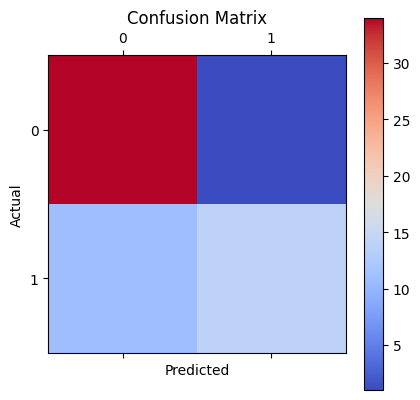

In [59]:
# Visualization: Confusion Matrix

plt.matshow(conf_matrix, cmap="coolwarm")
plt.title("Confusion Matrix")
plt.colorbar()
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.savefig('Visualizations/logistic_confusion_matrix.png')
plt.show()

In [60]:
# Linear Regression for Survival Time

X_linear = df.drop(columns=['time', 'death_event','death_event_label','gender'])
y_linear = df['time']
X_train_lin, X_test_lin, y_train_lin, y_test_lin = train_test_split(X_linear, y_linear, test_size=0.2, random_state=42)

In [61]:
linear_model = LinearRegression()
linear_model.fit(X_train_lin, y_train_lin)
y_pred_lin = linear_model.predict(X_test_lin)

In [62]:
# Linear Regression Evaluation

mse = mean_squared_error(y_test_lin, y_pred_lin)
r2 = r2_score(y_test_lin, y_pred_lin)
print("\nLinear Regression Performance:")
print("Mean Squared Error:", mse)
print("R-squared:", r2)


Linear Regression Performance:
Mean Squared Error: 5597.990189578112
R-squared: -0.020427300502624757


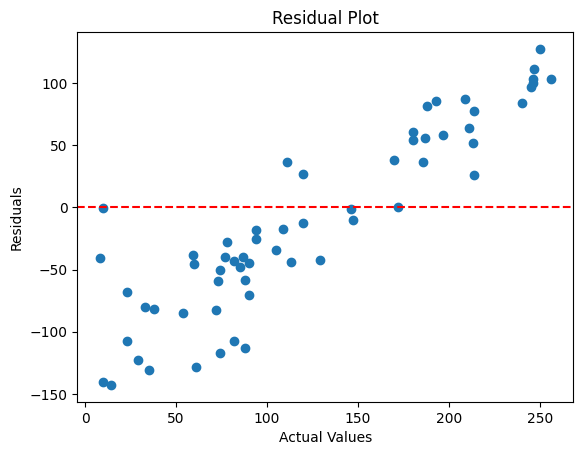

In [63]:
# Visualization: Residual Plot

residuals = y_test_lin - y_pred_lin
plt.scatter(y_test_lin, residuals)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residual Plot")
plt.xlabel("Actual Values")
plt.ylabel("Residuals")
plt.savefig('Visualizations/linear_residual_plot.png')
plt.show()

In [64]:
#Optimize model performance by tuning hyperparameters.
from sklearn.model_selection import GridSearchCV

param_grid = {'C': [0.01, 0.1, 1, 10, 100]}
grid_search = GridSearchCV(LogisticRegression(), param_grid, cv=5)
grid_search.fit(X_train, y_train)
print("Best Parameters:", grid_search.best_params_)

Best Parameters: {'C': 1}


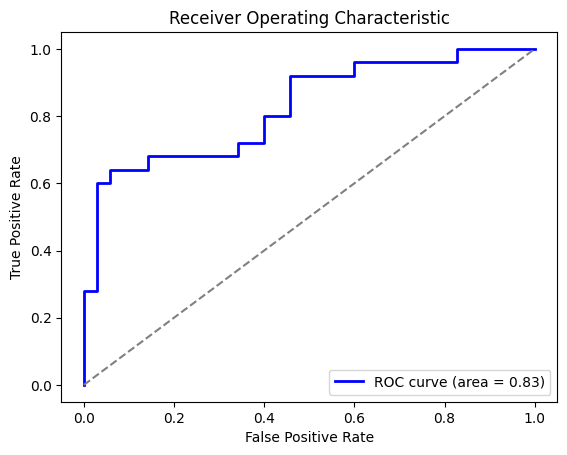

In [65]:
#generates an ROC (Receiver Operating Characteristic) curve and 
# calculates the AUC (Area Under the Curve) to evaluate the performance of my
#  logistic regression model.
from sklearn.metrics import roc_curve, auc

y_prob = logistic_model.predict_proba(X_test)[:, 1]  # Probability estimates
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.savefig('Visualizations/linear_roc.png')
plt.show()



    Understanding the Graph: X-axis (False Positive Rate - FPR): This represents the proportion of negatives (0s) that were incorrectly classified as positives (1s). In your case, these are the individuals who survived (DEATH_EVENT = 0) but were incorrectly predicted as having the event (death). The lower this value, the fewer false positives your model is generating. Y-axis (True Positive Rate - TPR): This represents the proportion of positives (1s) that were correctly classified as positives (1s). In your case, these are the individuals who actually had a death event (DEATH_EVENT = 1) and were correctly predicted as having the event. The higher this value, the better your model is at identifying the death event accurately. The blue ROC curve: Shows how well your model performs at various thresholds for classifying an individual as having a death event. The curve plots the trade-off between TPR and FPR for different threshold values (from 0 to 1). The diagonal grey line: Represents the performance of a random classifier. A random model, which doesn’t use any real predictive power, will have an ROC curve that follows this line. Any curve that lies above the grey line indicates better-than-random performance.
    What Does the AUC Tell You? The AUC (Area Under the Curve) quantifies the overall performance of the model by calculating the area under the ROC curve.

AUC = 1: A perfect model with no false positives or false negatives. AUC = 0.5: The model performs no better than random guessing (random classifier). AUC between 0.5 and 1: The model has some ability to distinguish between the two classes (death vs survival). A higher AUC means the model is better at making correct predictions. In your case, you can see from the label label='ROC curve (area = %0.2f)' % roc_auc on the graph what the exact AUC value is.

If AUC > 0.7, it indicates that your model is likely performing well in distinguishing between survivors and those who had the death event. If AUC is around 0.5, the model might not have much discriminative ability, and its performance is similar to random guessing. 3. Interpreting Your Model’s ROC Curve: Curve above the diagonal: If your ROC curve is well above the diagonal grey line, this indicates that your logistic regression model has some predictive power. The further the curve is from the diagonal, the better the model is at distinguishing between positive and negative cases. Curvature: The steeper the initial curve (closer to the top-left corner), the better your model is at classifying the positives with a low false positive rate. Area under the curve (AUC): If your AUC is close to 1, this is a good indicator that the model is effectively predicting the death events. If it's closer to 0.5, it suggests that the model is either performing poorly or just randomly predicting the outcomes. 4. What Else Can You Do? Threshold Tuning: The ROC curve allows you to evaluate your model’s performance at different thresholds for classification. By adjusting the threshold, you can either reduce false positives or false negatives, depending on your goal. For instance, if minimizing false negatives (predicting death events when they didn’t happen) is more important, you could adjust the threshold accordingly.

Compare Multiple Models: You could compare the ROC curves and AUC scores of different classification models (e.g., Logistic Regression, Decision Trees, SVMs, etc.) to see which one performs better in your case.


In [66]:
# Feature correlation analysis

correlations = df.drop(columns=['death_event_label','gender']).corr()
time_correlation = correlations["time"].sort_values(ascending=False)
print("\nCorrelation with Survival Time:\n", time_correlation)


Correlation with Survival Time:
 time                        1.000000
serum_sodium                0.087640
ejection_fraction           0.041729
diabetes                    0.033726
platelets                   0.010514
creatinine_phosphokinase   -0.009346
sex                        -0.015608
smoking                    -0.022839
anaemia                    -0.141414
serum_creatinine           -0.149315
high_blood_pressure        -0.196439
age                        -0.224068
death_event                -0.526964
Name: time, dtype: float64


In [67]:
# Feature correlation analysis

time_correlation = correlations["death_event"].sort_values(ascending=False)
print("\nCorrelation with Death Event:\n", time_correlation)


Correlation with Death Event:
 death_event                 1.000000
serum_creatinine            0.294278
age                         0.253729
high_blood_pressure         0.079351
anaemia                     0.066270
creatinine_phosphokinase    0.062728
diabetes                   -0.001943
sex                        -0.004316
smoking                    -0.012623
platelets                  -0.049139
serum_sodium               -0.195204
ejection_fraction          -0.268603
time                       -0.526964
Name: death_event, dtype: float64


c:\Users\Shari\Desktop\Data Science Course\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning:

X does not have valid feature names, but LogisticRegression was fitted with feature names



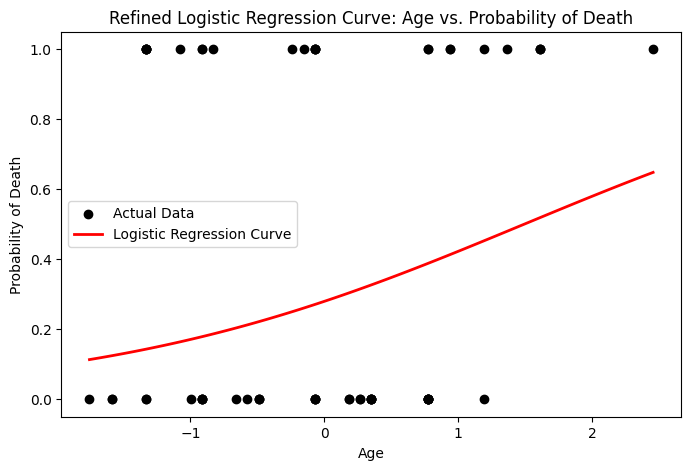

In [68]:
# Train a logistic regression model using only 'age'
X_age = X_train[['age']]  # Training set with only 'age'
X_age_test = X_test[['age']]  # Test set with only 'age'
model_age = LogisticRegression(max_iter=1000)
model_age.fit(X_age, y_train)

# Generate probabilities for a range of 'age'
age_range = np.linspace(X_age_test['age'].min(), X_age_test['age'].max(), 100).reshape(-1, 1)
probabilities_age = model_age.predict_proba(age_range)[:, 1]

# Plot the refined logistic regression curve
plt.figure(figsize=(8, 5))
plt.scatter(X_age_test, y_test, color='black', label='Actual Data')
plt.plot(age_range, probabilities_age, color='red', linewidth=2, label='Logistic Regression Curve')
plt.xlabel('Age')
plt.ylabel('Probability of Death')
plt.title('Refined Logistic Regression Curve: Age vs. Probability of Death')
plt.legend()
plt.savefig('Visualizations/logistic_regression_curve.png')
plt.show()

Gradient Boosting

In [69]:
# Separating features "X" from target variable "y"
y = df ['death_event'] # target/dependent variables
X = df.drop(columns=['death_event','death_event_label','gender']) # features/independent variables
# Separating data into training and test
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [70]:
# Scaling Dataset

# Instantiate a StandardScaler instance
scaler = StandardScaler()

# Fit the training data to the standard scaler
X_scaler = scaler.fit(X_train)

# Transform the training data using the scaler
X_train_scaled = X_scaler.transform(X_train)

# Transform the testing data using the scaler
X_test_scaled = X_scaler.transform(X_test)

In [71]:
# Using XGBoot as the gradient boosting classifier model

#training the model

clf = XGBClassifier(max_depth=5)
clf.fit(X_train_scaled, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [72]:
# Predict on the test set
y_pred_xgboost = clf.predict(X_test_scaled)

In [86]:
target_labels = ["Not Deceased","Deceased"]
print(classification_report(y_test, y_pred_xgboost, target_names=target_labels))

              precision    recall  f1-score   support

Not Deceased       0.78      0.86      0.82        44
    Deceased       0.77      0.65      0.70        31

    accuracy                           0.77        75
   macro avg       0.77      0.75      0.76        75
weighted avg       0.77      0.77      0.77        75



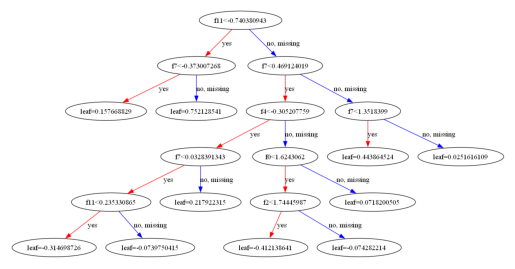

In [74]:
from xgboost import plot_tree
import matplotlib.pyplot as plt
plot_tree(clf)

# Visualizing a single decision tree (the first)
plt.savefig('Visualizations/gb_decision_tree')
plt.show()

Neural Network

In [75]:
# Split data into features and target arrays

y = df['death_event'].values
X = df.drop(['death_event','death_event_label','gender'], axis='columns').values

# Split data into a training and testing dataset

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [76]:
# Create a  StandardScaler Instance
scaler = StandardScaler()

# Fit StandardScaler
X_scaler = scaler.fit(X_train)

# Scale data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

Auto Optimization

In [77]:
# Create a method that creates a new Sequential model with hyperparameter options
def create_model(hp):
    nn_model = tf.keras.models.Sequential()

    # Allow kerastuner to decide which activation function to use in hidden layers
    activation = hp.Choice('activation',['relu','tanh','sigmoid'])

    # Allow kerastuner to decide number of neurons in first layer
    nn_model.add(tf.keras.layers.Dense(units=hp.Int('first_units',
        min_value=1,
        max_value=75,
        step=2), activation=activation, input_dim=12))

    # Allow kerastuner to decide number of hidden layers and neurons in hidden layers
    for i in range(hp.Int('num_layers', 1, 6)):
        nn_model.add(tf.keras.layers.Dense(units=hp.Int('units_' + str(i),
            min_value=1,
            max_value=5,
            step=2),
            activation=activation))

    nn_model.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

    # Compile the model
    nn_model.compile(loss="binary_crossentropy", optimizer='adam', metrics=["accuracy"])

    return nn_model

In [79]:
# Import the kerastuner library
import keras_tuner as kt

tuner = kt.Hyperband(
    create_model,
    objective="val_accuracy",
    max_epochs=20,
    hyperband_iterations=2)

c:\Users\Shari\Desktop\Data Science Course\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



In [80]:
# Run the kerastuner search for best hyperparameters
tuner.search(X_train_scaled,y_train,epochs=20,validation_data=(X_test_scaled,y_test))

Trial 60 Complete [00h 00m 03s]
val_accuracy: 0.5866666436195374

Best val_accuracy So Far: 0.8133333325386047
Total elapsed time: 00h 02m 49s


In [81]:
# Get best model hyperparameters
best_hyper = tuner.get_best_hyperparameters(1)[0]
best_hyper.values

{'activation': 'tanh',
 'first_units': 55,
 'num_layers': 1,
 'units_0': 5,
 'units_1': 5,
 'units_2': 1,
 'units_3': 5,
 'units_4': 3,
 'units_5': 1,
 'tuner/epochs': 20,
 'tuner/initial_epoch': 0,
 'tuner/bracket': 0,
 'tuner/round': 0}

In [82]:
# Evaluate best model against full test data
best_model = tuner.get_best_models(1)[0]
model_loss, model_accuracy = best_model.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

3/3 - 0s - 58ms/step - accuracy: 0.8133 - loss: 0.5080
Loss: 0.5079918503761292, Accuracy: 0.8133333325386047


In [83]:
best_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 55)             │           715 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,001 (3.91 KB)

 Trainable params: 1,001 (3.91 KB)

 Non-trainable params: 0 (0.00 B)

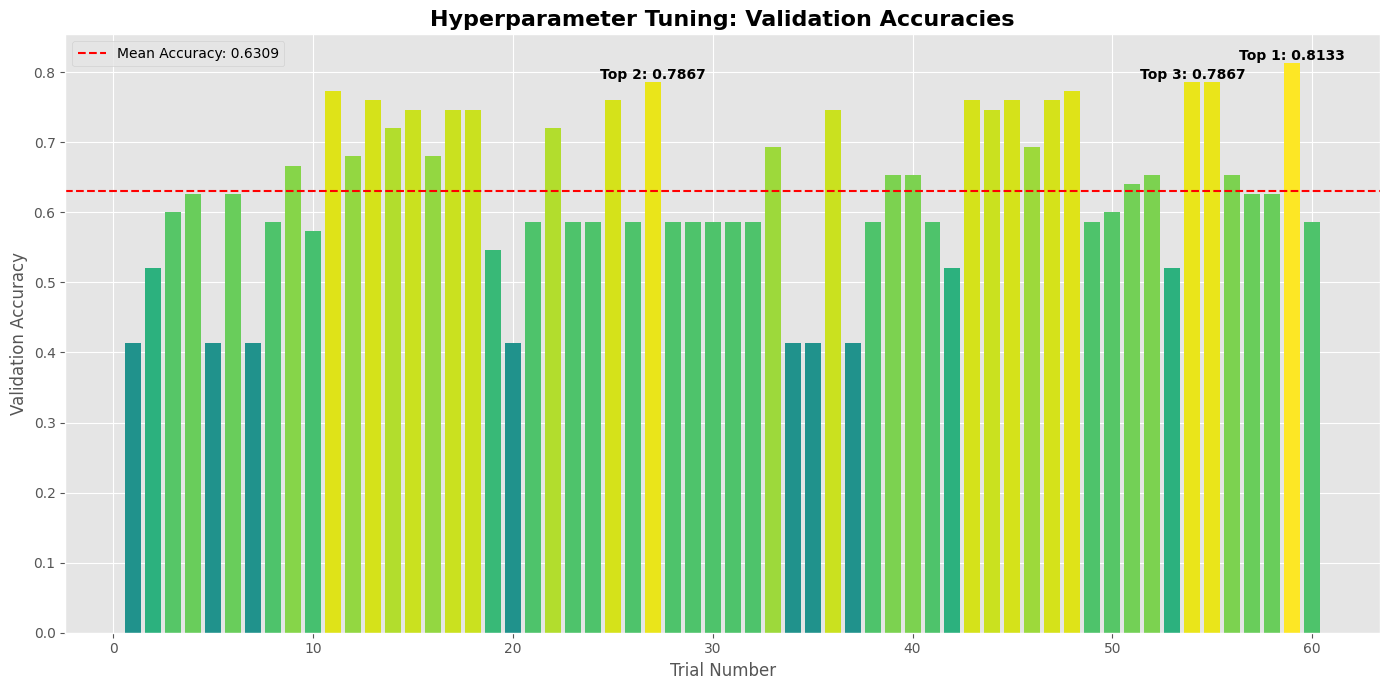


Top 5 Trials:
    Trial Number  Validation Accuracy  \
58            59             0.813333   
26            27             0.786667   
53            54             0.786667   
54            55             0.786667   
47            48             0.773333   

                                      Hyperparameters  
58  {'activation': 'tanh', 'first_units': 55, 'num...  
26  {'activation': 'tanh', 'first_units': 73, 'num...  
53  {'activation': 'tanh', 'first_units': 71, 'num...  
54  {'activation': 'tanh', 'first_units': 71, 'num...  
47  {'activation': 'tanh', 'first_units': 71, 'num...  

Best Trial Details:
Trial Number: 59
Validation Accuracy: 0.8133
Hyperparameters:
activation: tanh
first_units: 55
num_layers: 1
units_0: 5
units_1: 5
units_2: 1
units_3: 5
units_4: 3
units_5: 1
tuner/epochs: 20
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0


In [84]:
import matplotlib.pyplot as plt

# Set a professional, clean style
plt.style.use('ggplot')

# Create a list to store trial information
trial_results = []

# Iterate through all trials
for trial in tuner.oracle.trials.values():
    # Check if the trial has a score and is completed
    if hasattr(trial, 'score') and trial.score is not None and trial.status == 'COMPLETED':
        trial_results.append({
            'Trial Number': len(trial_results) + 1,
            'Validation Accuracy': trial.score,
            'Hyperparameters': trial.hyperparameters.values
        })

# Convert to DataFrame
results_df = pd.DataFrame(trial_results)

# Sort by validation accuracy in descending order
results_df = results_df.sort_values('Validation Accuracy', ascending=False)

# Create an enhanced plot
plt.figure(figsize=(14, 7))
bars = plt.bar(results_df['Trial Number'], results_df['Validation Accuracy'], 
               color=plt.cm.viridis(results_df['Validation Accuracy'] / results_df['Validation Accuracy'].max()))

# Customize the plot
plt.title('Hyperparameter Tuning: Validation Accuracies', 
          fontsize=16, fontweight='bold')
plt.xlabel('Trial Number', fontsize=12)
plt.ylabel('Validation Accuracy', fontsize=12)

# Add a horizontal line for the mean accuracy
mean_accuracy = results_df['Validation Accuracy'].mean()
plt.axhline(mean_accuracy, color='r', linestyle='--', 
            label=f'Mean Accuracy: {mean_accuracy:.4f}')

# Annotate top 3 trials
top_3_trials = results_df.head(3)
for i, (index, row) in enumerate(top_3_trials.iterrows(), 1):
    plt.text(row['Trial Number'], row['Validation Accuracy'], 
             f'Top {i}: {row["Validation Accuracy"]:.4f}', 
             horizontalalignment='center', 
             verticalalignment='bottom',
             fontweight='bold')

plt.legend()
plt.tight_layout()
plt.show()

# Print detailed information about top 5 trials
print("\nTop 5 Trials:")
print(results_df.head())

# Detailed best trial information
best_trial = results_df.iloc[0]
print("\nBest Trial Details:")
print(f"Trial Number: {best_trial['Trial Number']}")
print(f"Validation Accuracy: {best_trial['Validation Accuracy']:.4f}")
print("Hyperparameters:")
for param, value in best_trial['Hyperparameters'].items():
    print(f"{param}: {value}")